In [72]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from datetime import datetime
import os
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score
%matplotlib inline

In [2]:
stock_price = pd.read_csv("../dataset/stock_price_data/Pfizer_data.csv")
stock_price['Date'] = pd.to_datetime(stock_price['Date'], format = '%Y-%m-%d')
# pd.to_datetime(stock_price['Date'], format = '%Y-%m-%d').apply(pd.Timestamp)
# stock_price['Date']

In [3]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-01,35.930000,36.020000,35.430000,35.430000,34.060383,20885200
1,2019-10-02,35.259998,35.270000,34.660000,34.700001,33.358604,21307400
2,2019-10-03,34.709999,35.470001,34.599998,35.450001,34.079609,20945100
3,2019-10-04,35.490002,35.980000,35.450001,35.930000,34.541054,17139800
4,2019-10-07,35.820000,36.259998,35.799999,35.830002,34.444920,11156900


In [4]:
pfizer_close = stock_price['Close']
n = 7
moving_avg = [sum(pfizer_close[i-n:i])/n for i in range(n, len(pfizer_close))]
moving_stdev = (pfizer_close[n:] - moving_avg)**2

m = 3
moving_stdev_smooth = [sum(moving_stdev[i-m:i])/m for i in range(m,len(moving_stdev))]

dates = pd.to_datetime(stock_price["Date"], format = '%Y-%m-%d')
dates.head()


0   2019-10-01
1   2019-10-02
2   2019-10-03
3   2019-10-04
4   2019-10-07
Name: Date, dtype: datetime64[ns]

/Users/suraj/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


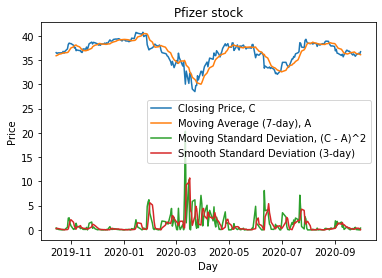

In [5]:
plt.plot(dates[n+m:], pfizer_close[n+m:], label="Closing Price, C")
plt.plot(dates[n+m:], moving_avg[m:], label=f"Moving Average ({n}-day), A")
plt.plot(dates[n+m:], moving_stdev[m:], label="Moving Standard Deviation, (C - A)^2")
plt.plot(dates[n+m:], moving_stdev_smooth, label=f"Smooth Standard Deviation ({m}-day)")
plt.title("Pfizer stock")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Price")
plt.rcParams["figure.figsize"]=(15,5) # (width, height)
plt.show()

In [6]:
def load_text(p):
    doc_list = []
    for f in os.listdir(p):
        if f[0] == '.':
            continue
        date = pd.Timestamp((f.split(','))[0])
        with open(os.path.join(p,f),'r') as doc:
            content = (date, doc.read())
            doc_list.append(content)
    return np.array(doc_list)

def fix_weekends(txt_df):
#     txt_df['Dates'] = pd.to_datetime(txt_df.Dates)
    dts = txt_df['Dates'][:]
    for date in range(len(dts)):
        if (dts[date].dayofweek - 4) > 0:
            dts[date] = dts[date] + (pd.offsets.Day(7 - (dts[date].dayofweek)))
    txt_df['Dates'] = dts
    
def load_volatility(p, volatility_threshold=1):
    labels = [(1,dates[i+m+n]) if j > volatility_threshold else (0,dates[i+m+n]) for i,j in enumerate(moving_stdev_smooth)]
    return np.array(labels)

def load_data(text_path, price_path):
    text = load_text(text_path)
    text_df = pd.DataFrame({'Dates':pd.to_datetime(text[:,0]),'Text':text[:,1]})
    fix_weekends(text_df)
    volatility = load_volatility(price_path)
    vol_df = pd.DataFrame({'Dates':pd.to_datetime(volatility[:,1]),'Volatility':volatility[:,0]})
    return text_df.merge(vol_df, on='Dates', how='left')
        
    

In [30]:

pfizer_text_path = '../dataset/marketwatch_articles/Pfizer'
text = load_text(pfizer_text_path)

pfizer_price_path = '../dataset/stock_price_data/Pfizer_data.csv'
data = load_data(pfizer_text_path, pfizer_price_path)

display(data)
dat = data[data['Volatility'].notna()]
X = dat['Text']
y = dat['Volatility']
y=y.astype('int')

,Dates,Text,Volatility
0,2019-11-08,"Merck KGaA, Pfizer drug fails to meet endpoint...",0
1,2020-08-26,"Walgreens Boots, UnitedHealth share losses con...",0
2,2020-01-13,Biogen to buy from Pfizer an asset to develop ...,0
3,2020-08-07,Pfizer to help manufacture Gilead's remdesivir...,0
4,2019-12-13,Dow's 50-point drop led by losses in shares of...,0
...,...,...,...
429,2020-08-12,Moderna Joins Ranks of U.S. Covid-Vaccine Deal...,0
430,2020-03-03,These are the 10 biggest stock winners Monday ...,1
431,2020-05-06,Dow's 75-point jump highlighted by gains for s...,0
432,2020-07-20,"Pfizer, BioNTech COVID-19 vaccine candidate in...",1


In [31]:
print(type(y.values[207]))
print(data.Dates.values[207])

<class 'numpy.int64'>
2019-12-25T00:00:00.000000000


In [32]:
vectorizer = CountVectorizer(token_pattern='\\w{2,}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
print(f"train len = {len(y_train)}, test len = {len(y_test)}")
print(y_train.values)

train len = 288, test len = 142
[0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1
 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0
 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1
 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0
 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0]


In [51]:
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)

In [75]:
model = LogisticRegression()
print(X_train_vec.shape)
model.fit(X_train_vec, y_train)

y_pred = model.predict(vectorizer.transform(X_test))
print((y_pred))
print(f1_score(y_test, y_pred, average='binary'))
print(f1_score(y_test, y_pred, average='weighted'))
print(roc_auc_score(y_test, y_pred))

(288, 8497)
[1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0
 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1]
0.6666666666666666
0.7670600177642432
0.7430434782608697


In [ ]:

#alternative for labeling
# djia = pd.read_csv("../dataset/stock_price_data/DJIA_data.csv")
# djia_data = djia['Close']
# np_cov = np.array([np.cov(pfizer_close[i-n:i], djia_data[i-n:i])[0,1]/n for i in range(n, len(pfizer_close))])
# np_cov[:10]
# djia = pd.read_csv("../dataset/stock_price_data/DJIA_data.csv")
# djia_data = djia['Close']
# np_cov = np.array([np.cov(pfizer_close[i-n:i], djia_data[i-n:i])[0,1]/n for i in range(n, len(pfizer_close))])
# np_cov[:10]
# plt.plot(dates[n+m:], pfizer_close[n+m:], label="Pfizer Price")
# plt.plot(dates[n+m:], djia_data[m+n-1:]/1000, label="DJIA price")
# plt.plot(dates[n+m:], np_cov[2:-1]/10, label='np_cov')
# plt.legend()
# plt.show()